In [25]:
import datetime
import billboard
import pandas as pd
import spotipy
from collections import defaultdict
from spotipy.oauth2 import SpotifyClientCredentials


# Initiate the dictionary to store artist data
artist_data = defaultdict(int)

# Set the date for 5 years ago
date = datetime.datetime.now() - datetime.timedelta(weeks=5*52)

# Loop over each week for the past 5 years
while date < datetime.datetime.now():
    # Fetch the top 100 songs for this week
    chart = billboard.ChartData('hot-100', date=date.strftime('%Y-%m-%d'))

    # Loop over each song in the chart
    for song in chart:
        # Loop over each artist for the song (songs can have multiple artists)
        for artist in song.artist.split(' Featuring '):
            # Increment the number of weeks this artist has been in the top 100
            artist_data[artist] += 1

    # Increment the date by one week
    date += datetime.timedelta(weeks=1)

# Convert the artist data into a DataFrame
df = pd.DataFrame(list(artist_data.items()), columns=['Artist', 'Total Chart Entries Weekly for Past 5 years'])

# Sort the DataFrame by the number of weeks in the top 100
df = df.sort_values('Total Chart Entries Weekly for Past 5 years', ascending=False)

# Print the top 10 artists
print(df.head(10))



            Artist  Total Chart Entries Weekly for Past 5 years
0            Drake                                          842
52   Morgan Wallen                                          637
75        Lil Baby                                          502
27    Taylor Swift                                          436
518       Doja Cat                                          378
32      Luke Combs                                          378
1      Post Malone                                          370
361         DaBaby                                          337
391            SZA                                          310
170  Billie Eilish                                          281


In [26]:
# Set up Spotify API client
client_credentials_manager = SpotifyClientCredentials(client_id='xxx', client_secret='xxx')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Initiate the dictionary to store artist data
artist_data = defaultdict(list)

# Set the date for 10 weeks ago
date = datetime.datetime.now() - datetime.timedelta(weeks=10)

# Loop over each week for the past 10 weeks
for _ in range(10):
    # Store the top song for each artist this week
    weekly_data = defaultdict(lambda: {'song': None, 'score': 101})

    # Fetch the top 100 songs for this week
    chart = billboard.ChartData('hot-100', date=date.strftime('%Y-%m-%d'))

    # Loop over each song in the chart
    for song in chart:
        # Loop over each artist for the song (songs can have multiple artists)
        for artist in song.artist.split(' Featuring '):
            # If this song has a higher position than the current top song for this artist, update it
            if song.rank < weekly_data[artist]['score']:
                weekly_data[artist] = {'song': song.title, 'score': song.rank}

    # Increment the date by one week
    date += datetime.timedelta(weeks=1)

    # Fetch the audio features for the top song for each artist this week and add them to the artist data
    for artist, data in weekly_data.items():
        # Search for the song on Spotify to get its ID
        results = sp.search(q='track:' + data['song'], type='track')

        # Get the first track from the search results, if any
        if results['tracks']['items']:
            track = results['tracks']['items'][0]
        else:
            print(f"No search results for: {data['song']}")
            continue  # Skip to the next song

        # Fetch the audio features for the track
        audio_features = sp.audio_features(tracks=[track['id']])

        # Check if audio features were found
        if audio_features[0] is not None:
            # Add the audio features to the artist data
            artist_data[artist].append(audio_features[0])
        else:
            # If no audio features were found, add an empty dictionary
            artist_data[artist].append({})

# Calculate the average audio features for each artist over the past 10 weeks
for artist, data in artist_data.items():
    avg_data = defaultdict(float)
    for features in data:
        for feature, value in features.items():
            if isinstance(value, (int, float)):  # Make sure the value is a number
                avg_data[feature] += value
    artist_data[artist] = {feature: value / len(data) for feature, value in avg_data.items()}

# Convert the artist data into a list of dictionaries
data_list = [{'Artist': artist, **features} for artist, features in artist_data.items()]

# Convert the list into a DataFrame
df = pd.DataFrame(data_list)

# Print the top 10 artists sorted by a feature, say 'acousticness'
print(df.sort_values('acousticness', ascending=False).head(10))


                       Artist  danceability  energy   key  loudness  mode  \
50                    Rihanna         0.247   0.299   9.0    -6.083   1.0   
49              Maggie Rogers         0.447   0.441   0.0    -7.658   1.0   
129                   Shakira         0.748   0.478  11.0    -8.886   1.0   
106             David Kushner         0.508   0.430   2.0    -9.475   0.0   
98                 Jack Black         0.698   0.312  10.0   -10.900   0.0   
43                      Lizzo         0.604   0.199   0.0   -11.831   1.0   
23            Stephen Sanchez         0.551   0.550  10.0    -5.339   1.0   
73                 Coco Jones         0.584   0.453   8.0    -6.682   1.0   
82   Rosalia & Rauw Alejandro         0.768   0.644   5.0    -6.671   0.0   
48              The Kid LAROI         0.662   0.398  11.0    -6.691   0.0   

     speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
50        0.0315         0.899          0.000000     0.131    0.172  177

In [27]:
# Get the top 10 artists from the Billboard charts over the past 5 years
artist_data = defaultdict(int)
date = datetime.datetime.now() - datetime.timedelta(weeks=5*52)
while date < datetime.datetime.now():
    chart = billboard.ChartData('hot-100', date=date.strftime('%Y-%m-%d'))
    for song in chart:
        for artist in song.artist.split(' Featuring '):
            artist_data[artist] += 1
    date += datetime.timedelta(weeks=1)

df = pd.DataFrame(list(artist_data.items()), columns=['Artist', 'Total Chart Entries Weekly for Past 5 years'])
df = df.sort_values('Total Chart Entries Weekly for Past 5 years', ascending=False)
top_artists = df['Artist'].head(10).values

# Fetch the audio features for the top songs of the top artists
top_artist_features = defaultdict(list)
for artist in top_artists:
    results = sp.search(q='artist:' + artist, type='track')
    if results['tracks']['items']:
        for track in results['tracks']['items']:
            audio_features = sp.audio_features(tracks=[track['id']])
            if audio_features[0] is not None:
                top_artist_features[artist].append(audio_features[0])

# Calculate the average audio features for each top artist
avg_artist_features = {}
for artist, features in top_artist_features.items():
    avg_features = defaultdict(float)
    for feature in features:
        for name, value in feature.items():
            if isinstance(value, (int, float)):
                avg_features[name] += value
    avg_artist_features[artist] = {name: value / len(features) for name, value in avg_features.items()}

# Convert the artist data into a DataFrame
df_avg_features = pd.DataFrame(list(avg_artist_features.items()), columns=['Artist', 'Average Audio Features'])



# Print the DataFrame
print(df_avg_features)


          Artist                             Average Audio Features
0          Drake  {'danceability': 0.7140000000000001, 'energy':...
1  Morgan Wallen  {'danceability': 0.6025, 'energy': 0.7357, 'ke...
2       Lil Baby  {'danceability': 0.8412, 'energy': 0.5211, 'ke...
3   Taylor Swift  {'danceability': 0.639, 'energy': 0.6066, 'key...
4       Doja Cat  {'danceability': 0.7866000000000002, 'energy':...
5     Luke Combs  {'danceability': 0.5541, 'energy': 0.6833, 'ke...
6    Post Malone  {'danceability': 0.6637, 'energy': 0.638200000...
7         DaBaby  {'danceability': 0.8097, 'energy': 0.669700000...
8            SZA  {'danceability': 0.5969, 'energy': 0.5718, 'ke...
9  Billie Eilish  {'danceability': 0.4901, 'energy': 0.2633, 'ke...


In [28]:
df_avg_features['Average Audio Features'] = df_avg_features['Average Audio Features'].apply(lambda x: str(x).replace('{', '').replace('}', '').replace("'", ''))
df_avg_features = df_avg_features.sort_values('Artist')
#expand the features into separate columns
df_avg_features = df_avg_features.join(df_avg_features['Average Audio Features'].str.split(',', expand=True).add_prefix('feature_'))
df_avg_features = df_avg_features.drop('Average Audio Features', axis=1)
print(df_avg_features)
df_avg_features

          Artist                         feature_0  \
9  Billie Eilish              danceability: 0.4901   
7         DaBaby              danceability: 0.8097   
4       Doja Cat  danceability: 0.7866000000000002   
0          Drake  danceability: 0.7140000000000001   
2       Lil Baby              danceability: 0.8412   
5     Luke Combs              danceability: 0.5541   
1  Morgan Wallen              danceability: 0.6025   
6    Post Malone              danceability: 0.6637   
8            SZA              danceability: 0.5969   
3   Taylor Swift               danceability: 0.639   

                     feature_1  feature_2                       feature_3  \
9               energy: 0.2633   key: 4.8   loudness: -12.908599999999998   
7   energy: 0.6697000000000001   key: 4.6               loudness: -5.6906   
4               energy: 0.6562   key: 7.0    loudness: -5.533199999999999   
0               energy: 0.5043   key: 5.5                loudness: -8.071   
2               ener

,Artist,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12
9,Billie Eilish,danceability: 0.4901,energy: 0.2633,key: 4.8,loudness: -12.908599999999998,mode: 0.6,speechiness: 0.08626999999999999,acousticness: 0.8140000000000001,instrumentalness: 0.16589797,liveness: 0.11592,valence: 0.23220000000000002,tempo: 115.87259999999999,duration_ms: 215307.5,time_signature: 3.8
7,DaBaby,danceability: 0.8097,energy: 0.6697000000000001,key: 4.6,loudness: -5.6906,mode: 0.7,speechiness: 0.30026,acousticness: 0.09800800000000001,instrumentalness: 5.84e-07,liveness: 0.15053999999999998,valence: 0.6006,tempo: 131.7386,duration_ms: 143969.4,time_signature: 4.0
4,Doja Cat,danceability: 0.7866000000000002,energy: 0.6562,key: 7.0,loudness: -5.533199999999999,mode: 0.6,speechiness: 0.12008,acousticness: 0.21389,instrumentalness: 0.00437834,liveness: 0.16585,valence: 0.595,tempo: 118.09949999999999,duration_ms: 184357.4,time_signature: 4.0
0,Drake,danceability: 0.7140000000000001,energy: 0.5043,key: 5.5,loudness: -8.071,mode: 0.6,speechiness: 0.15914,acousticness: 0.0671267,instrumentalness: 0.010400786,liveness: 0.19114,valence: 0.29600000000000004,tempo: 135.3875,duration_ms: 236414.4,time_signature: 3.9
2,Lil Baby,danceability: 0.8412,energy: 0.5211,key: 5.5,loudness: -7.312900000000001,mode: 0.0,speechiness: 0.29511,acousticness: 0.109874,instrumentalness: 6.57e-07,liveness: 0.1559,valence: 0.36740000000000006,tempo: 121.01880000000001,duration_ms: 165162.4,time_signature: 3.9
5,Luke Combs,danceability: 0.5541,energy: 0.6833,key: 5.8,loudness: -5.5259,mode: 1.0,speechiness: 0.03246,acousticness: 0.1834,instrumentalness: 1.2499999999999999e-06,liveness: 0.17208,valence: 0.5094000000000001,tempo: 118.70290000000003,duration_ms: 215573.3,time_signature: 4.0
1,Morgan Wallen,danceability: 0.6025,energy: 0.7357,key: 6.9,loudness: -5.1964,mode: 0.7,speechiness: 0.032279999999999996,acousticness: 0.328854,instrumentalness: 0.000108653,liveness: 0.21399999999999997,valence: 0.5459,tempo: 154.54840000000002,duration_ms: 182738.6,time_signature: 3.9
6,Post Malone,danceability: 0.6637,energy: 0.6382000000000001,key: 5.0,loudness: -5.2045,mode: 0.7,speechiness: 0.06505,acousticness: 0.204436,instrumentalness: 0.00025118799999999995,liveness: 0.14261,valence: 0.4791,tempo: 117.15950000000001,duration_ms: 186688.7,time_signature: 4.0
8,SZA,danceability: 0.5969,energy: 0.5718,key: 5.2,loudness: -7.5601,mode: 0.5,speechiness: 0.06841,acousticness: 0.33233,instrumentalness: 0.05654680999999999,liveness: 0.21059,valence: 0.42910000000000004,tempo: 112.299,duration_ms: 189048.1,time_signature: 3.9
3,Taylor Swift,danceability: 0.639,energy: 0.6066,key: 6.0,loudness: -7.062299999999999,mode: 0.8,speechiness: 0.06116000000000001,acousticness: 0.22353,instrumentalness: 0.000145757,liveness: 0.18957,valence: 0.34615,tempo: 118.1842,duration_ms: 230222.6,time_signature: 3.9


In [29]:
#Put them in the order of most popular artists (e.g. Drake, Morgan Wallen etc
df_avg_features = df_avg_features.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# change column names to be more descriptive
df_avg_features = df_avg_features.rename(columns={'feature_0': 'danceability', 'feature_1': 'energy', 'feature_2': 'key', 'feature_3': 'loudness', 'feature_4': 'mode', 'feature_5': 'speechiness', 'feature_6': 'acousticness', 'feature_7': 'instrumentalness', 'feature_8': 'liveness', 'feature_9': 'valence', 'feature_10': 'tempo', 'feature_11': 'type', 'feature_12': 'id', 'feature_13': 'uri', 'feature_14': 'track_href', 'feature_15': 'analysis_url', 'feature_16': 'duration_ms', 'feature_17': 'time_signature'})

df_avg_features


,Artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id
0,Drake,danceability: 0.7140000000000001,energy: 0.5043,key: 5.5,loudness: -8.071,mode: 0.6,speechiness: 0.15914,acousticness: 0.0671267,instrumentalness: 0.010400786,liveness: 0.19114,valence: 0.29600000000000004,tempo: 135.3875,duration_ms: 236414.4,time_signature: 3.9
1,Morgan Wallen,danceability: 0.6025,energy: 0.7357,key: 6.9,loudness: -5.1964,mode: 0.7,speechiness: 0.032279999999999996,acousticness: 0.328854,instrumentalness: 0.000108653,liveness: 0.21399999999999997,valence: 0.5459,tempo: 154.54840000000002,duration_ms: 182738.6,time_signature: 3.9
2,Lil Baby,danceability: 0.8412,energy: 0.5211,key: 5.5,loudness: -7.312900000000001,mode: 0.0,speechiness: 0.29511,acousticness: 0.109874,instrumentalness: 6.57e-07,liveness: 0.1559,valence: 0.36740000000000006,tempo: 121.01880000000001,duration_ms: 165162.4,time_signature: 3.9
3,Taylor Swift,danceability: 0.639,energy: 0.6066,key: 6.0,loudness: -7.062299999999999,mode: 0.8,speechiness: 0.06116000000000001,acousticness: 0.22353,instrumentalness: 0.000145757,liveness: 0.18957,valence: 0.34615,tempo: 118.1842,duration_ms: 230222.6,time_signature: 3.9
4,Doja Cat,danceability: 0.7866000000000002,energy: 0.6562,key: 7.0,loudness: -5.533199999999999,mode: 0.6,speechiness: 0.12008,acousticness: 0.21389,instrumentalness: 0.00437834,liveness: 0.16585,valence: 0.595,tempo: 118.09949999999999,duration_ms: 184357.4,time_signature: 4.0
5,Luke Combs,danceability: 0.5541,energy: 0.6833,key: 5.8,loudness: -5.5259,mode: 1.0,speechiness: 0.03246,acousticness: 0.1834,instrumentalness: 1.2499999999999999e-06,liveness: 0.17208,valence: 0.5094000000000001,tempo: 118.70290000000003,duration_ms: 215573.3,time_signature: 4.0
6,Post Malone,danceability: 0.6637,energy: 0.6382000000000001,key: 5.0,loudness: -5.2045,mode: 0.7,speechiness: 0.06505,acousticness: 0.204436,instrumentalness: 0.00025118799999999995,liveness: 0.14261,valence: 0.4791,tempo: 117.15950000000001,duration_ms: 186688.7,time_signature: 4.0
7,DaBaby,danceability: 0.8097,energy: 0.6697000000000001,key: 4.6,loudness: -5.6906,mode: 0.7,speechiness: 0.30026,acousticness: 0.09800800000000001,instrumentalness: 5.84e-07,liveness: 0.15053999999999998,valence: 0.6006,tempo: 131.7386,duration_ms: 143969.4,time_signature: 4.0
8,SZA,danceability: 0.5969,energy: 0.5718,key: 5.2,loudness: -7.5601,mode: 0.5,speechiness: 0.06841,acousticness: 0.33233,instrumentalness: 0.05654680999999999,liveness: 0.21059,valence: 0.42910000000000004,tempo: 112.299,duration_ms: 189048.1,time_signature: 3.9
9,Billie Eilish,danceability: 0.4901,energy: 0.2633,key: 4.8,loudness: -12.908599999999998,mode: 0.6,speechiness: 0.08626999999999999,acousticness: 0.8140000000000001,instrumentalness: 0.16589797,liveness: 0.11592,valence: 0.23220000000000002,tempo: 115.87259999999999,duration_ms: 215307.5,time_signature: 3.8


In [30]:
# Delete names of features in column cells to only have numbers left
df_avg_features['danceability'] = df_avg_features['danceability'].str.replace('danceability: ', '')
df_avg_features['energy'] = df_avg_features['energy'].str.replace('energy: ', '')
df_avg_features['key'] = df_avg_features['key'].str.replace('key: ', '')
df_avg_features['loudness'] = df_avg_features['loudness'].str.replace('loudness: ', '')
df_avg_features['mode'] = df_avg_features['mode'].str.replace('mode: ', '')
df_avg_features['speechiness'] = df_avg_features['speechiness'].str.replace('speechiness: ', '')
df_avg_features['acousticness'] = df_avg_features['acousticness'].str.replace('acousticness: ', '')
df_avg_features['instrumentalness'] = df_avg_features['instrumentalness'].str.replace('instrumentalness: ', '')
df_avg_features['liveness'] = df_avg_features['liveness'].str.replace('liveness: ', '')
df_avg_features['valence'] = df_avg_features['valence'].str.replace('valence: ', '')
df_avg_features['tempo'] = df_avg_features['tempo'].str.replace('tempo: ', '')
df_avg_features

,Artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id
0,Drake,0.7140000000000001,0.5043,5.5,-8.071,0.6,0.15914,0.0671267,0.010400786,0.19114,0.29600000000000004,135.3875,duration_ms: 236414.4,time_signature: 3.9
1,Morgan Wallen,0.6025,0.7357,6.9,-5.1964,0.7,0.032279999999999996,0.328854,0.000108653,0.21399999999999997,0.5459,154.54840000000002,duration_ms: 182738.6,time_signature: 3.9
2,Lil Baby,0.8412,0.5211,5.5,-7.312900000000001,0.0,0.29511,0.109874,6.57e-07,0.1559,0.36740000000000006,121.01880000000001,duration_ms: 165162.4,time_signature: 3.9
3,Taylor Swift,0.639,0.6066,6.0,-7.062299999999999,0.8,0.06116000000000001,0.22353,0.000145757,0.18957,0.34615,118.1842,duration_ms: 230222.6,time_signature: 3.9
4,Doja Cat,0.7866000000000002,0.6562,7.0,-5.533199999999999,0.6,0.12008,0.21389,0.00437834,0.16585,0.595,118.09949999999999,duration_ms: 184357.4,time_signature: 4.0
5,Luke Combs,0.5541,0.6833,5.8,-5.5259,1.0,0.03246,0.1834,1.2499999999999999e-06,0.17208,0.5094000000000001,118.70290000000003,duration_ms: 215573.3,time_signature: 4.0
6,Post Malone,0.6637,0.6382000000000001,5.0,-5.2045,0.7,0.06505,0.204436,0.00025118799999999995,0.14261,0.4791,117.15950000000001,duration_ms: 186688.7,time_signature: 4.0
7,DaBaby,0.8097,0.6697000000000001,4.6,-5.6906,0.7,0.30026,0.09800800000000001,5.84e-07,0.15053999999999998,0.6006,131.7386,duration_ms: 143969.4,time_signature: 4.0
8,SZA,0.5969,0.5718,5.2,-7.5601,0.5,0.06841,0.33233,0.05654680999999999,0.21059,0.42910000000000004,112.299,duration_ms: 189048.1,time_signature: 3.9
9,Billie Eilish,0.4901,0.2633,4.8,-12.908599999999998,0.6,0.08626999999999999,0.8140000000000001,0.16589797,0.11592,0.23220000000000002,115.87259999999999,duration_ms: 215307.5,time_signature: 3.8


In [31]:
df_avg_features

,Artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id
0,Drake,0.7140000000000001,0.5043,5.5,-8.071,0.6,0.15914,0.0671267,0.010400786,0.19114,0.29600000000000004,135.3875,duration_ms: 236414.4,time_signature: 3.9
1,Morgan Wallen,0.6025,0.7357,6.9,-5.1964,0.7,0.032279999999999996,0.328854,0.000108653,0.21399999999999997,0.5459,154.54840000000002,duration_ms: 182738.6,time_signature: 3.9
2,Lil Baby,0.8412,0.5211,5.5,-7.312900000000001,0.0,0.29511,0.109874,6.57e-07,0.1559,0.36740000000000006,121.01880000000001,duration_ms: 165162.4,time_signature: 3.9
3,Taylor Swift,0.639,0.6066,6.0,-7.062299999999999,0.8,0.06116000000000001,0.22353,0.000145757,0.18957,0.34615,118.1842,duration_ms: 230222.6,time_signature: 3.9
4,Doja Cat,0.7866000000000002,0.6562,7.0,-5.533199999999999,0.6,0.12008,0.21389,0.00437834,0.16585,0.595,118.09949999999999,duration_ms: 184357.4,time_signature: 4.0
5,Luke Combs,0.5541,0.6833,5.8,-5.5259,1.0,0.03246,0.1834,1.2499999999999999e-06,0.17208,0.5094000000000001,118.70290000000003,duration_ms: 215573.3,time_signature: 4.0
6,Post Malone,0.6637,0.6382000000000001,5.0,-5.2045,0.7,0.06505,0.204436,0.00025118799999999995,0.14261,0.4791,117.15950000000001,duration_ms: 186688.7,time_signature: 4.0
7,DaBaby,0.8097,0.6697000000000001,4.6,-5.6906,0.7,0.30026,0.09800800000000001,5.84e-07,0.15053999999999998,0.6006,131.7386,duration_ms: 143969.4,time_signature: 4.0
8,SZA,0.5969,0.5718,5.2,-7.5601,0.5,0.06841,0.33233,0.05654680999999999,0.21059,0.42910000000000004,112.299,duration_ms: 189048.1,time_signature: 3.9
9,Billie Eilish,0.4901,0.2633,4.8,-12.908599999999998,0.6,0.08626999999999999,0.8140000000000001,0.16589797,0.11592,0.23220000000000002,115.87259999999999,duration_ms: 215307.5,time_signature: 3.8


In [63]:
df_avg_features['danceability']= df_avg_features['danceability'].astype(float).round(3)
df_avg_features['energy']= df_avg_features['energy'].astype(float).round(3)
df_avg_features['loudness']= df_avg_features['loudness'].astype(float).round(3)
df_avg_features['speechiness']= df_avg_features['speechiness'].astype(float).round(3)
df_avg_features['acousticness']= df_avg_features['acousticness'].astype(float).round(3)
df_avg_features['instrumentalness']= df_avg_features['instrumentalness'].astype(float).round(3)
df_avg_features['liveness']= df_avg_features['liveness'].astype(float).round(3)
df_avg_features['valence']= df_avg_features['valence'].astype(float).round(3)
df_avg_features['tempo']= df_avg_features['tempo'].astype(float).round(3)

In [64]:
df_avg_features

,Artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id
0,Drake,0.714,0.504,5.5,-8.071,0.6,0.159,0.067,0.010,0.191,0.296,135.388,duration_ms: 236414.4,time_signature: 3.9
1,Morgan Wallen,0.602,0.736,6.9,-5.196,0.7,0.032,0.329,0.000,0.214,0.546,154.548,duration_ms: 182738.6,time_signature: 3.9
2,Lil Baby,0.841,0.521,5.5,-7.313,0.0,0.295,0.110,0.000,0.156,0.367,121.019,duration_ms: 165162.4,time_signature: 3.9
3,Taylor Swift,0.639,0.607,6.0,-7.062,0.8,0.061,0.224,0.000,0.190,0.346,118.184,duration_ms: 230222.6,time_signature: 3.9
4,Doja Cat,0.787,0.656,7.0,-5.533,0.6,0.120,0.214,0.004,0.166,0.595,118.099,duration_ms: 184357.4,time_signature: 4.0
5,Luke Combs,0.554,0.683,5.8,-5.526,1.0,0.032,0.183,0.000,0.172,0.509,118.703,duration_ms: 215573.3,time_signature: 4.0
6,Post Malone,0.664,0.638,5.0,-5.204,0.7,0.065,0.204,0.000,0.143,0.479,117.160,duration_ms: 186688.7,time_signature: 4.0
7,DaBaby,0.810,0.670,4.6,-5.691,0.7,0.300,0.098,0.000,0.151,0.601,131.739,duration_ms: 143969.4,time_signature: 4.0
8,SZA,0.597,0.572,5.2,-7.560,0.5,0.068,0.332,0.057,0.211,0.429,112.299,duration_ms: 189048.1,time_signature: 3.9
9,Billie Eilish,0.490,0.263,4.8,-12.909,0.6,0.086,0.814,0.166,0.116,0.232,115.873,duration_ms: 215307.5,time_signature: 3.8


In [65]:
df_avg_features.to_csv('avg_features_df.csv')

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



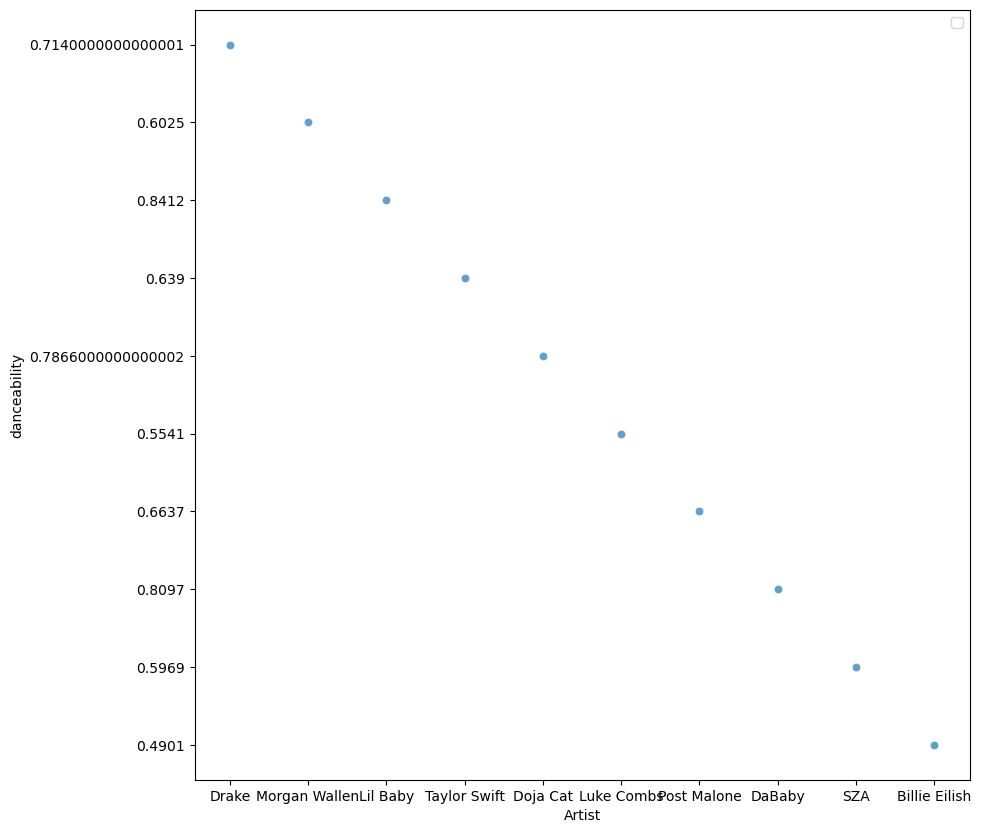

In [34]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data= df_avg_features, x='Artist', y='danceability', 
                      palette='rainbow', 
                      sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

In [35]:
import plotnine
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_abline, geom_smooth,theme, element_text

In [66]:
dance_graph = (ggplot(df_avg_features, aes('Artist','danceability'))
 + geom_point()+ theme(axis_text_x = element_text(angle=90)
 ))

dance_graph.save(filename='danceability.png', dpi= 300)

/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: danceability.png


In [67]:
energy_graph = (ggplot(df_avg_features, aes('Artist','energy'))
 + geom_point() + theme(axis_text_x = element_text(angle=90)
 )
 )
energy_graph.save(filename='energy.png', dpi=300)

/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: energy.png


In [68]:
key_graph = (ggplot(df_avg_features, aes('Artist','key'))
 + geom_point()
 + theme(axis_text_x = element_text(angle=90)
 ))

key_graph.save(filename='key.png', dpi=300)

/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: key.png


In [69]:
loudness_graph = (ggplot(df_avg_features, aes('Artist','loudness'))
 + geom_point()
 +  theme(axis_text_x = element_text(angle=90)
 ))

loudness_graph.save(filename='loudness.png', dpi=300)

/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: loudness.png


In [70]:
mode_graph = (ggplot(df_avg_features, aes('Artist','mode'))
 + geom_point() +  theme(axis_text_x = element_text(angle=90)
 )
 )
mode_graph.save(filename='mode.png', dpi=300)

/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: mode.png


In [71]:
speechiness_graph = (ggplot(df_avg_features, aes('Artist','speechiness'))
 + geom_point() +  theme(axis_text_x = element_text(angle=90)
 )
 )
speechiness_graph.save(filename='speechiness.png', dpi= 300)

/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/tbyfield/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: speechiness.png


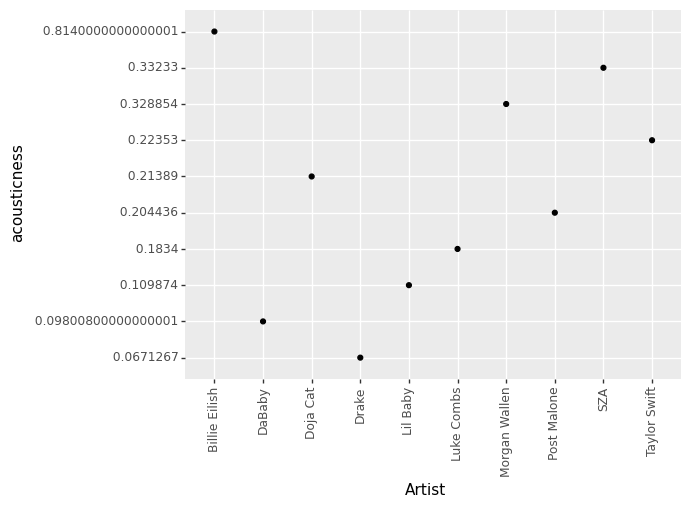

<ggplot: (8764898874019)>

In [42]:
(ggplot(df_avg_features, aes('Artist','acousticness'))
 + geom_point() + theme(axis_text_x = element_text(angle=90)
 )
 )

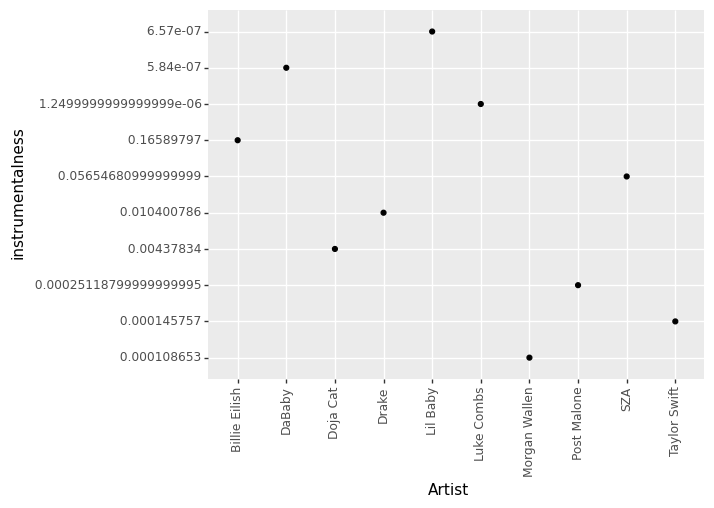

<ggplot: (8764898808757)>

In [43]:
(ggplot(df_avg_features, aes('Artist','instrumentalness'))
 + geom_point() +  theme(axis_text_x = element_text(angle=90)
 )
 )

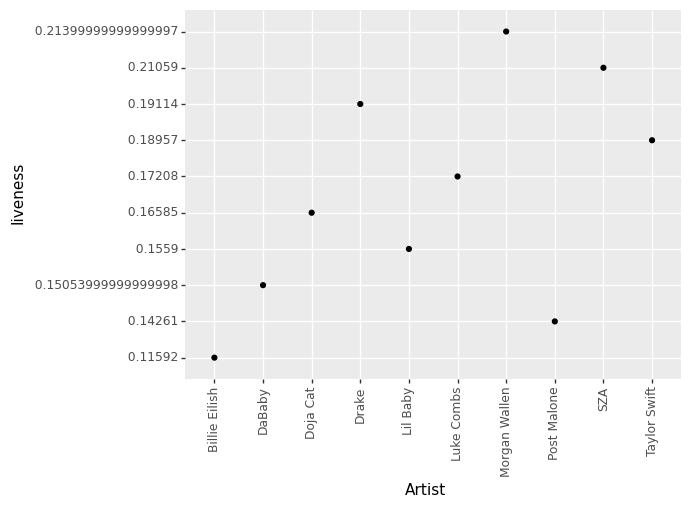

<ggplot: (8764866085111)>

In [44]:
(ggplot(df_avg_features, aes('Artist','liveness'))
 + geom_point() +  theme(axis_text_x = element_text(angle=90)
 )
 )

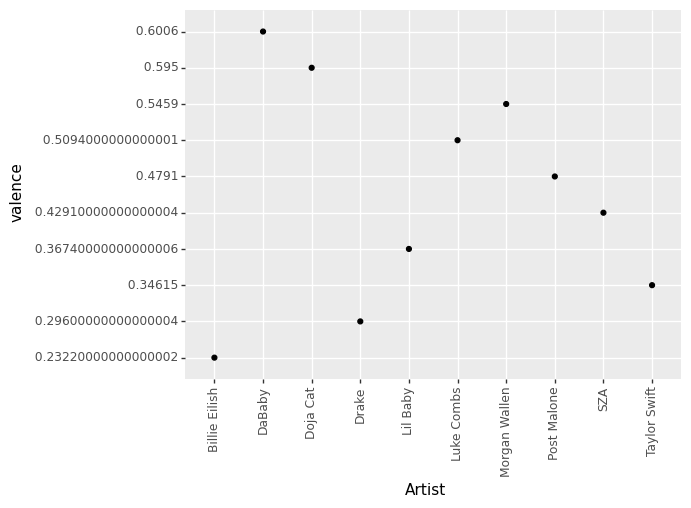

<ggplot: (8764829237197)>

In [45]:
(ggplot(df_avg_features, aes('Artist','valence'))
 + geom_point() +  theme(axis_text_x = element_text(angle=90)
 )
 )